In [1]:
import operator
import os
from re import A
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
BASE_URL = os.getenv("BASE_URL")

In [7]:
model = ChatOpenAI(
    model="Qwen/Qwen2.5-7B-Instruct",
    api_key=API_KEY,
    base_url=BASE_URL
)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    user_intent: str

# === 1️⃣ 意图识别节点 ===
def user_intent(state: AgentState):
    user_message = state["messages"][-1].content
    prompt = ChatPromptTemplate.from_template("""
    You are an intent classification assistant.
    Given the user message, classify it into one of these intents:
    - query_wether
    - book_ticket
    - complain_service
    If none apply, respond with "unknown".

    User message: {message}
    """)
    chain = prompt | model
    response = chain.invoke({"message": user_message})
    intent = response.content.strip().lower()
    return {"messages": [AIMessage(content=f"Identified intent: {intent}")], "user_intent": intent}

def query_wether(state: AgentState):
    whether_result = "Today is sunny with a high of 25°C."
    return {"messages": [AIMessage(content=whether_result)]}

def book_ticket(state: AgentState):
    booking_confirmation = "Your ticket has been booked successfully."
    return {"messages": [AIMessage(content=booking_confirmation)]}

def complain_service(state: AgentState):
    complaint_response = "Your complaint has been registered. We will get back to you shortly."
    return {"messages": [AIMessage(content=complaint_response)]}

def route_to_skill(state: AgentState):
    intent = state["user_intent"]
    if intent == "query_wether":
        return "query_wether"
    elif intent == "book_ticket":
        return "book_ticket"
    elif intent == "complain_service":
        return "complain_service"
    else:
        return END

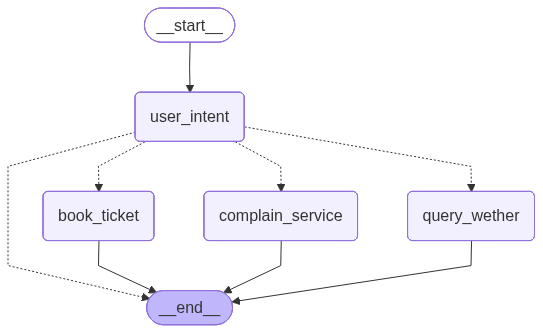

In [13]:
# 构建图
builder = StateGraph(AgentState)
builder.add_node("user_intent", user_intent)
builder.add_node("query_wether", query_wether)
builder.add_node("book_ticket", book_ticket)
builder.add_node("complain_service", complain_service)

builder.add_edge(START, "user_intent")
builder.add_conditional_edges(
    "user_intent",
    route_to_skill,  # 决定下一个节点
    {
        "query_wether": "query_wether",
        "book_ticket": "book_ticket",
        "complain_service": "complain_service",
        END: END
    }
)
# 其他节点执行完后直接结束
builder.add_edge("query_wether", END)
builder.add_edge("book_ticket", END)
builder.add_edge("complain_service", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"messages": [HumanMessage(content="Help me book a flight")]})
print(result["messages"][-1].content)

Your ticket has been booked successfully.
